<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing-performance" data-toc-modified-id="Comparing-performance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing performance</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Future-scope" data-toc-modified-id="Future-scope-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Future scope</a></span></li></ul></div>

## Comparing performance

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.externals import joblib
   
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In this notebook, we will compare the performance of the different models.  Let's start by loading the R_2 from each model, which we saved in the previous notebooks.

In [2]:
# Load R_2 from different models
r2_lin = joblib.load('../saved_models/r2_lin.joblib')
r2_xgb = joblib.load('../saved_models/r2_xgb.joblib')

In [3]:
## Add performance from XGBoost
# First convert it to data frame
r2_xgb_df = pd.DataFrame({'Train': {'XGBoost': np.NaN,},
                          'Test': {'XGBoost': r2_xgb}})
# Append and sort
r2_df = r2_lin.append(r2_xgb_df) \
    .sort_values(by='Test', 
                 ascending=False)

Now we can plot a bar chart comparing the explained variance for each model.  Note that **color is used to distinguish the linear models with and without regularization**.

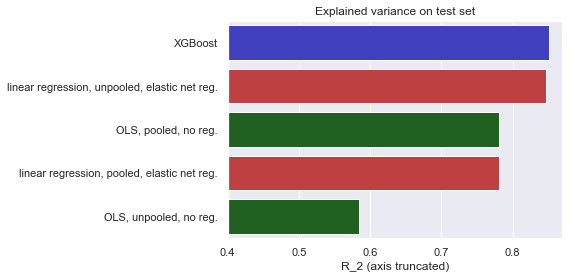

In [4]:
sns.barplot(x=r2_df.Test,
            y=r2_df.index,
            palette=['blue', 'red', 'green', 'red', 'green'],
            saturation=0.5)
plt.xlim([0.4, 0.87])
plt.xlabel('R_2 (axis truncated)')
plt.title('Explained variance on test set')
plt.show();

We see that the best performance is achieved by gradient boosting as well as the unpooled linear model with elastic net regularization.  There are two main reasons that a (regularized) linear model is able to keep up with gradient boosting in this case: Firstly, the number of observations as well as variables is too low for gradient boosting to get anywhere close to its capacity.  Nevertheless, it is reassuring to see that gradient boosting performs at least as well as the linear model, even in the case where the odds are stacked against it.  

In addition, most of the predictors used for the linear model were dummy variables (e.g., intercepts for the metropolitan area or the hotel category), and only a small proportion of variables were actually modeled linearly (age, square footage, etc.). 
A second insight is how important regularization is: If we do not use regularization, the pooled model performs best.  This is because the unpooled model contains so many predictors that it strongly overfits the data in the absence of regularization.  Employing regularization thus allows us to use the information from important categorical variables with many different values, such as location.

Note that adding regularization does not make any noticeable difference for the pooled case. This is not too surprising: In the unpooled case, adding dummies for hundreds of locations and affiliations of the sold hotel led to a proliferation of variables, so regularization is necessary to prevent overfitting. 

Conversely, in the unpooled case, since we have about 7000 observations and only 37 variables, a linear model seems to have virtually reached its capacity: The number of observations is high enough that there is basically no overfitting, and as a result regularization does not yield any noticeable improvement. A second reason why regularization turned out not to be necessary in this case is that I'm using a data set in which the variables have already been pre-selected to optimize it for use with OLS.  If I had access to the full data set, it is likely that regularization would have an edge, because it is able to intelligently select which variables contain useful information in which mainly contain noise.


Finally, let's compare the performance of the linear models on the training and test set to get a better understanding of why the idea of using a separate test set is useful

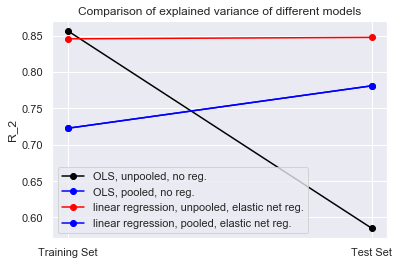

In [22]:
# Plot
r2_lin.T \
      .plot(marker='o', 
            color=['black', 'blue', 'red', 'blue'])
plt.xticks(ticks=[0, 1], 
           labels=['Training Set', 'Test Set'])
plt.ylabel('R_2')
plt.title('Comparison of explained variance of different models')
plt.show();

For then unpooled model without regularization ( black ), we get the typical result: Since it contains a lot of variables (roughly 1000) compared to the number of observations (about 7000), its explained variance is substantially higher on the test set than on the training set. If we add regularization (red line) the performance between training and test set becomes more equalized. 
If we look at the pooled models (both plotted in blue because they overlap almost completely), we see that regularization does not make a noticeable difference.  This is due to the fact that these pooled models are characterized by a small number of variables (35) relative to the number of observations (7000).  This seems to be more than enough to prevent overfitting.  In other words, a linear model has long reached its capacity, and is thus not flexible enough to adapt to the noise rather than the signal in the data.  
What is surprising, though, is that the pooled models perform quite a bit better on the test set than on the training set. The difference seems too big to be solely due to randomness (though this may be hard to say intuitively, and we could look at the standard error for the R_2 estimates that cross-validation can give us). Instead, the most likely explanation for how this difference can be so large (in the opposite direction as expected) is that we did not use random splitting of the data, but rather use the later portion of the data as the test set. As a result, the training and test set do not come from the same distribution, and it seems that the test set it is easier to predict.  This could be due to the fact that we have much more data for newer years, and so the intercept for the year could be estimated more precisely.  Thus, even though we had to treat the new data as if they were from the last year from which we had data, this may still have been more accurate than estimating the effect of year for years for which we only had a few observations.

## Conclusion
Overall, this analysis successfully demonstrates that a state-of-the-art machine learning model performs as least as good as OLS, even in situations that seem to be stacked against it, such as a small data set (7000 observations) for which the predictors were already hand-selected to be relevant (rather than letting the model sort this out).
Furthermore, eve does not n though the best linear model could keep up with gradient boosting, this was dependent on choosing the right specifications. For instance, if we use a linear time trend rather than dummy variables for the individual years (not shown in these notebooks), the linear model does not reach the performance of gradient boosting. (Note that it is not obvious that this specification is a worse choice, because in fact the pooled model did much better with a linear time trend.) Since gradient boosting does not make any assumptions about the distribution of the data, we do not have to rely on any a priori assumptions about how to model the data.  
As a result, while gradient boosting is a complex algorithm, it is in some important ways easier to use.  The biggest challenge is tuning the hyperparameters, but this process is increasingly becoming automated with the rise of Automated Machine Learning (AutoML). 

This brings us to the second goal of this analysis, namely to show that – independently of whether more sophisticated models from machine learning such as gradient boosting are adopted – there are also gains to be made from adapting practices from machine learning such as regularization and the use of a separate test set. While using regularization does not always yield noticeable improvements (see the pooled case), it is still good practice to always do so, because it is rarely easy to intuitively decide beforehand whether it will. Furthermore, the additional effort involved is small, and it actually saves time in other ways, because we do not have to think as hard about which variables to include and which to exclude.  

Likewise, this analysis demonstrated how important it is to use a second central technique from machine learning, namely the practice of withholding data when training the model, and then evaluating the model only on these data.  Precisely *because* machine learning models are more complex, there has been a greater emphasis on developing tools to make model checking easier.  In particular, the practice of measuring predictive performance on withheld data offers a simpler and more reliable alternative to applied statistics' heavy use of test statistics that are based on a lot of mathematics as well as often dubious assumptions. Without this technique it would have been impossible to say with confidence whether, for example, the pooled or unpooled model is preferable, or exactly how much better gradient boosting is likely to perform on new data.


## Future scope
While we could try different learning algorithms, and combine these into an ensemble to get a presumably small improvement in accuracy, the biggest gains are likely to be had from training the gradient boosting model on better data.  As already mentioned, I used data optimized for OLS to show that gradient boosting is preferable even in cases where the odds are stacked against it.  

Firstly, it would be very interesting to see how much the edge of gradient boosting increases if we added back the extra features that were discarded.  Ideally, we would go back and get the original data for the older wave.  However, it might also be sufficient to only use the data we have, and add the extra features from the newer wave while leaving them as missing for the older wave.  

Likewise, we should try to increase the number of observations.  This could simply be done by not discarding any rows with missing values. (Note that this was done so as to not disadvantage OLS, since there are no good tools available yet that perform a multivariate imputation on the training set and then apply the same transformation on the test set. The next version of scikit-learn is scheduled to fix this, though.)  

Since location is one of the most important attributes affecting price, we should also focus on engineering better features that measure location at a more fine-ingrained level.  For example, since hotel sales are much more sparse than data on residential housing prices, we could use the latter to estimate the desirability of a specific micro-location, and then include this as an additional feature.

Finally, it would be interesting to estimate learning curves, to see if there are any circumstances in which linear regression should still be the preferred model.  In this calculation, it might also be interesting to vary not only the number of observations but also the number of features.

In [1]:
import os
os.system('jupyter nbconvert --to html 3_comparison.ipynb')

0